# 基于有向无环图的多区域洁净室渗透气流网络构建

依据多区域洁净厂房静态运行时，房间压差、渗风等元素成对稳定存在且相互依赖的特点，构建一个加权的有向无环图（Directed Acyclic Graph，DAG）来描述多区域洁净室渗透气流网络，具体表述为：

$$G = (V,E,W)$$

其中，$V$ 是顶点集合，$E$ 是有向边集合，$W$ 是权重函数。

$V$ 中每个顶点 $v_i$ 代表一个房间，其属性包括房间的编号、压差和洁净度等级。有向边集 $E$ 通过有向边 $e_{ij}$ 表示各房间的相邻关系及压差梯度导致的渗风方向，即从高压区 $v_i$ 指向低压区 $v_j$。渗风主要通过门窗缝隙在相邻房间之间传播，而边的有向性自然指示了渗风方向。权重函数 $W$ 将房间之间的有向边 $e_{ij}$ 映射至正实数权重 $w_{ij}$，以量化表示从高压区 $v_i$ 指向低压区 $v_j$ 的渗风强度，与房间之间的压差成正比。权重参考门缝渗风的函数关系设置为：

$$w_{ij} = \Delta p^{0.5}_{ij} = |p_{i} - p_{j}|^{0.5}$$

以此，分别构建当前工况图 $G_c$ 与设计工况图 $G_d$。为了定量衡量多区域洁净厂房系统各房间压差控制效果与设计值的差异，需要将 $G_c$ 与 $G_d$ 进行比较。在考虑每个顶点的压差属性、边的方向和权重的基础上，提出有效压差梯度系数 $I_{DPGD}$ 以量化表示多区域洁净厂房系统各房间压差控制效果与设计值的差异。

# 基于图的压差梯度差异性指标（Differential pressure gradient discrepancy，$I_{\rm{DPGD}}$）

## 指标设计目标

$I_{\rm{DPGD}}$ 应当能够反映多区域洁净室在不同工况下压差梯度的差异性。

在进行风平衡和压差控制时，可以用来衡量当前压差梯度工况图 $G_c$ 与设计图 $G_d$ 之间的差异，以便于进一步分析压差控制的有效性。

## 指标设计原则

1. $I_{\rm{DPGD}}$ 应当能够反映多区域洁净室在不同工况下压差梯度的差异性。当 $I_{\rm{DPGD}} > 0$ 时，表示存在差异；当 $I_{\rm{DPGD}} < 0$ 时，表示逆压差梯度（高洁净度房间压差低于低洁净度房间），应该是错误工况； 当 $I_{\rm{DPGD}} = 0$ 时，表示完全一致，各房间压差较设计值绝对误差均为 0（特殊情况）。
2. $I_{\rm{DPGD}}$ 的变化应与节点压差属性的绝对误差同步，且洁净度越高的房间影响越大。
3. $I_{\rm{DPGD}}$ 的变化应与边权重属性的绝对误差同步，且洁净度越高的房间影响越大。
4. $I_{\rm{DPGD}}$ 的变化应与逆压差梯度（高洁净度房间压差低于低洁净度房间）的发生同步，当逆压差梯度发生时，对应节点间边的方向相反（权重固定为正实数），此时应当有 $I_{\rm{DPGD}} < 0$。

## 模型

In [1]:
import networkx as nx
from pydantic import BaseModel, field_validator, model_validator
from typing_extensions import Self


class CleanroomData(BaseModel):
    """多区域洁净室压差与渗透方向数据

    Raises:
        ValueError: rooms 和 room_pressures 应该等长
        ValueError: room_relations 中的元素必须是 rooms 中的元素
        ValueError: room_relations 中不应该出现双向关系

    Returns:
        CleanroomData: 多区域洁净室压差与渗透方向数据
    """

    rooms: list[str]  # [room_name, ...]
    room_pressures: list[float]  # [pressure, ...]
    room_relations: list[tuple[str, str]]  # [(rom1, rom2), ...], rom1 -> rom2

    @model_validator(mode="after")
    def check_rooms_len(self) -> Self:
        if len(self.rooms) != len(self.room_pressures):
            raise ValueError("rooms 和 room_pressures 应该等长")
        return self

    @model_validator(mode="after")
    def check_room_relations(self) -> Self:
        if not all(set(relation) <= set(self.rooms) for relation in self.room_relations):
            raise ValueError("room_relations 中的元素必须是 rooms 中的元素")
        return self

    @field_validator("room_relations")
    @classmethod
    def check_room_relations_reverse(cls, v):
        for relation in v:
            if relation[::-1] in v:
                raise ValueError("room_relations 中不应该出现双向关系")
        return v


def cal_ew_press(node1, node2):
    r"""计算两个节点之间的等效权重，若两个节点的压力差为负，则返回负值，否则返回正值。
    $$w_{ij} = \Delta p^{0.5}_{ij} = |p_{i} - p_{j}|^{0.5}$$
    """
    press_err = node1["pressure"] - node2["pressure"]

    if press_err < 0:
        rlt = -((-press_err) ** 0.5)
    else:
        rlt = press_err**0.5

    return rlt


def create_cleanroom_graph(
    data: CleanroomData,
    cal_edge_weight: callable,
) -> nx.DiGraph:
    """创建洁净室压差与渗透气流网络图

    该函数接受一个 CleanroomData 实例，返回一个有向图。
    图中的节点代表洁净室，边代表洁净室之间的压差关系。
    需要传入一个计算边权重的函数，该函数接受两个节点，返回边权重。
    边权重固定为正值，若计算出的边权重为负值，则将边的方向反转。

    Args:
        data (CleanroomData): 包含洁净室压差与渗透方向数据的实例
        cal_edge_weight (callable): 计算边权重的函数

    Returns:
        nx.DiGraph: 洁净室压差与渗透气流网络图
    """
    G = nx.DiGraph()
    G.add_nodes_from(
        [
            (room, {"pressure": pressure})
            for room, pressure in zip(data.rooms, data.room_pressures, strict=True)
        ]
    )
    for relation in data.room_relations:
        n1, n2 = relation
        weight = cal_edge_weight(G.nodes[n1], G.nodes[n2])

        if weight < 0:
            n1, n2 = n2, n1
            weight = -weight

            # 同时原地修改 data 中的 room_relations
            data.room_relations[data.room_relations.index(relation)] = (n1, n2)

        G.add_edge(n1, n2, weight=weight, nodes=(n1, n2))

    return G

## 图定义

### G_d 设计工况图

[('a', 'O', {'weight': 3.1622776601683795, 'nodes': ('a', 'O')}), ('b', 'a', {'weight': 2.23606797749979, 'nodes': ('b', 'a')}), ('c', 'b', {'weight': 3.1622776601683795, 'nodes': ('c', 'b')}), ('c', 'O', {'weight': 5.0, 'nodes': ('c', 'O')}), ('d', 'c', {'weight': 2.23606797749979, 'nodes': ('d', 'c')}), ('e', 'c', {'weight': 3.1622776601683795, 'nodes': ('e', 'c')}), ('e', 'd', {'weight': 2.23606797749979, 'nodes': ('e', 'd')}), ('f', 'c', {'weight': 2.23606797749979, 'nodes': ('f', 'c')})]


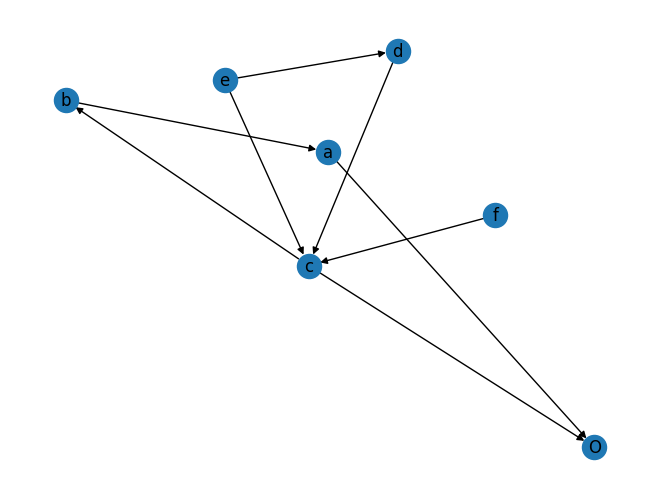

In [4]:
design_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[10, 15, 25, 30, 35, 30, 0],
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
G_d = create_cleanroom_graph(design_data, cal_ew_press)
print(G_d.edges(data=True))
nx.draw(G_d, with_labels=True)

### G_c 当前工况图

[('b', 'a'), ('c', 'b'), ('d', 'c'), ('e', 'c'), ('f', 'c'), ('e', 'd'), ('a', 'O'), ('c', 'O')]
[('a', 'O', {'weight': 2.8284271247461903, 'nodes': ('a', 'O')}), ('b', 'a', {'weight': 3.03315017762062, 'nodes': ('b', 'a')}), ('c', 'b', {'weight': 1.949358868961793, 'nodes': ('c', 'b')}), ('c', 'O', {'weight': 4.58257569495584, 'nodes': ('c', 'O')}), ('d', 'c', {'weight': 1.4142135623730951, 'nodes': ('d', 'c')}), ('e', 'c', {'weight': 4.242640687119285, 'nodes': ('e', 'c')}), ('e', 'd', {'weight': 4.0, 'nodes': ('e', 'd')}), ('f', 'c', {'weight': 2.23606797749979, 'nodes': ('f', 'c')})]
[('b', 'a'), ('c', 'b'), ('d', 'c'), ('e', 'c'), ('f', 'c'), ('e', 'd'), ('a', 'O'), ('c', 'O')]


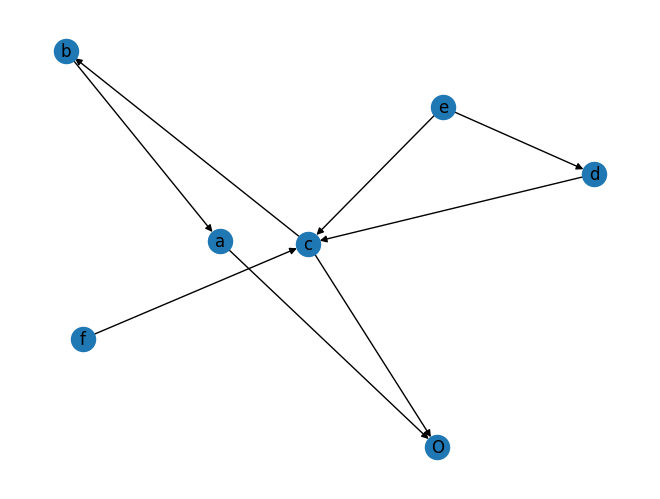

In [5]:
# 一组自定义的当前工况数据
custom_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[8, 17.2, 21, 23, 39, 26, 0],
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
print(custom_data.room_relations)
G_c = create_cleanroom_graph(custom_data, cal_ew_press)
print(G_c.edges(data=True))
print(custom_data.room_relations)
nx.draw(G_c, with_labels=True)

## API 测试

In [6]:
type(G_c.edges(data=True))

networkx.classes.reportviews.OutEdgeDataView

### 邻接矩阵

In [5]:
list(G_d.neighbors("c"))

['b', 'O']

In [6]:
G_d["a"]

AtlasView({'O': {'weight': 3.1622776601683795, 'nodes': ('a', 'O')}})

In [7]:
G_d.nodes.data()

NodeDataView({'a': {'pressure': 10.0}, 'b': {'pressure': 15.0}, 'c': {'pressure': 25.0}, 'd': {'pressure': 30.0}, 'e': {'pressure': 35.0}, 'f': {'pressure': 30.0}, 'O': {'pressure': 0.0}})

### 边

In [8]:
G_d["b"]["a"]

{'weight': 2.23606797749979, 'nodes': ('b', 'a')}

In [9]:
G_d.edges["b", "a"]

{'weight': 2.23606797749979, 'nodes': ('b', 'a')}

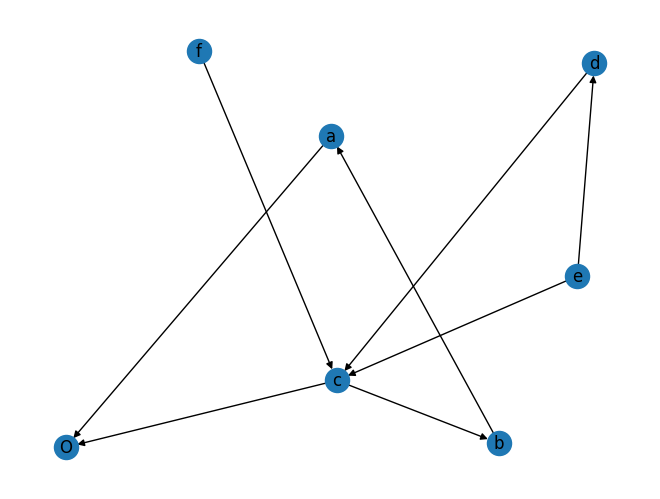

In [10]:
nx.draw(G_d, with_labels=True)

In [11]:
print(G_d.number_of_edges())
print(G_d.number_of_nodes())

8
7


## 压差梯度差异性指标计算

基于图编辑距离（Graph Edit Distance，GED）的思想，设计压差梯度差异性指标 $I_{\rm{DPGD}}$ 的计算方法。

GED 是一种用于计算两个图之间的相似性的方法，其基本思想是通过一系列的图编辑操作将一个图转换为另一个图，从而计算两个图之间的相似性。GED 的计算方法主要包括两个方面：顶点的插入、删除和替换操作，以及边的插入、删除和替换操作。

在计算 $I_{\rm{DPGD}}$ 时，考虑到多区域洁净室系统的特点，主要关注顶点的压差属性、边的方向和权重，这主要涉及到顶点的替换和边的替换操作，需要设计相应的代价。

### 顶点的替换代价

顶点的替换代价主要考虑 $G_c$ 相对于 $G_d$ 顶点压差属性的绝对误差和洁净度等级的影响，即：
1. 偏差：顶点压差属性的绝对误差越大，替换代价越高；
2. 洁净度：洁净度等级越高（设计压差越大），替换代价越高。

具体表述为：

$$C_{\mathrm{vertice}}\left(p_{i}^{c}, p_{i}^{d}\right)=k_{\mathrm{vertice}} \cdot\frac{p_{i}^{d}\cdot\left|p_{i}^{c}-p_{i}^{d}\right|}{\overline{p^d}^2}$$

其中，$p_i^c$ 是当前工况图中节点 $i$ 的压差；$p_i^d$ 是设计工况图中节点 $i$ 的设计压差；$\bar{p^d}$ 是设计压差的平均值；$k_{\text {vertice}}$ 是节点替换操作的基础代价系数。

In [7]:
from functools import partial

import numpy as np


def _node_subst_cost(node_d, node_c, p_d_mean, k_vertice=1, T=1):
    r"""返回节点替换的开销。
    以节点属性字典为输入，返回一个正数作为替换开销。

    $$C_{\mathrm{vertice}}\left(p_{i}^{c}, p_{i}^{d}\right) \\
      =k_{\mathrm{vertice}} \cdot\left(\frac{p_{i}^{d}\cdot \\
      \left|p_{i}^{c}-p_{i}^{d}\right|}{\overline{p^d}^2}\right)^{T}$$

    node_subst_cost(G1.nodes[n1], G2.nodes[n2]) -> float
    """
    p_d = node_d["pressure"]
    p_c = node_c["pressure"]
    cost = k_vertice * (p_d * abs(p_c - p_d)) / p_d_mean**2
    return cost


node_subst_cost = partial(
    _node_subst_cost,
    p_d_mean=np.mean(design_data.room_pressures),
    k_vertice=1,
    T=1,
)

### 边的替换代价

边的替换代价主要考虑 $G_c$ 相对于 $G_d$ 边权重属性的绝对误差和逆压差梯度的影响，即：

1. 偏差：边权重属性的绝对误差越大，替换代价越高；
2. 洁净度：边连接的两个顶点洁净度等级（最高设计压差）越高，替换代价越高；

具体表述为：

$$C_{\mathrm{edge} }\left(w_{i j}^{c}, w_{i j}^{d}\right)=k_{\mathrm{edge} } \cdot\frac{\max{(p_i^{d},p_j^{d})} \cdot \left|w_{i j}^{c}-w_{i j}^{d}\right|}{\overline{w^{d}}^3}$$

其中，$w_{ij}^c$ 是当前工况图中边 $e_{ij}$ 的权重；$w_{ij}^d$ 是设计工况图中边 $e_{ij}$ 的设计权重；$\bar{w^d}$ 是设计权重的平均值；$k_{\text {edge}}$ 是边替换操作的基础代价系数。

边的替换代价与顶点的替换代价类似，但更侧重于相邻节点的相对压差，对于压差梯度控制具有更强的指导意义，所以在计算 $I_{\rm{DPGD}}$ 时，边的替换代价应当占据更大的权重，即 $k_{\text {edge}} > k_{\text {vertice}}$。

In [8]:
def _edge_subst_cost(edge_d, edge_c, w_d_mean, k_edge=2, T=1):
    r"""返回边替换的开销。忽略边的方向。
    以边属性字典为输入，返回一个正数作为替换开销。

    $$C_{\mathrm{edge} }\left(w_{i j}^{c}, w_{i j}^{d}\right) \\
    =k_{\mathrm{edge} } \cdot\left(\frac{\max{(p_i^{d},p_j^{d})} \\
    \cdot \left|w_{i j}^{c}-w_{i j}^{d}\right|}{\overline{w^{d}}^3}\right)^{T}$$

    edge_subst_cost(G1.edges[e1], G2.edges[e2]) -> float
    """

    w_d = edge_d["weight"]
    w_c = edge_c["weight"]
    n1, n2 = edge_d["nodes"]
    p_i_d, p_j_d = G_d.nodes[n1]["pressure"], G_d.nodes[n2]["pressure"]
    cost = k_edge * (max(p_i_d, p_j_d) * abs(w_c - w_d)) / w_d_mean**3
    return cost


edge_subst_cost = partial(
    _edge_subst_cost,
    w_d_mean=np.mean([edge["weight"] for _, _, edge in G_d.edges(data=True)]),
    k_edge=2,
    T=1,
)

###  $I_{\rm{DPGD}}$ 的计算

In [9]:
def count_reversed_edges(G1, G2) -> int:
    """计算两个工况图中逆压差梯度的边数。"""
    edges_G1 = set(G1.edges())
    edges_G2 = set(G2.edges())
    reversed_count = 0
    for u, v in edges_G1:
        if (v, u) in edges_G2:
            reversed_count += 1

    return reversed_count


def DPGD(
    G_d,
    G_c,
    node_subst_cost=node_subst_cost,
    edge_subst_cost=edge_subst_cost,
    timeout=5,
) -> float:
    """计算压差梯度差异性指标。

    本质是对 nx graph_edit_distance 函数的封装。

    逆压差梯度：
    当逆压差梯度发生时，对应节点间边的方向相反（权重固定为正实数），需要特别处理。
    此时应当有 $I_{\rm{DPGD}} = -1$。每再有一条逆压差梯度的边，$I_{\rm{DPGD}} - 1$。
    """
    reversed_count = count_reversed_edges(G_d, G_c)
    if reversed_count > 0:
        return -reversed_count

    return nx.graph_edit_distance(
        G_d,
        G_c,
        node_subst_cost=node_subst_cost,
        edge_subst_cost=edge_subst_cost,
        timeout=timeout,
    )

In [21]:
ged = DPGD(G_d, G_c)
print(f"GED：{ged}")

GED：11.462741330111342


## 测试

针对提出的设计原则，设计测试用例以验证 $I_{\rm{DPGD}}$ 的有效性。具体测试用例包括。

1. **CT1** 设计工况图与当前工况图完全一致，即 $I_{\rm{DPGD}} = 0$；
2. **CT2** 设计工况图与当前工况图存在一定差异，即 $I_{\rm{DPGD}} > 0$；
   1. **CT3** 高洁净度房间会产生更大的影响；
3. **CT4** 设计工况图与当前工况图存在逆压差梯度，即 $I_{\rm{DPGD}} < 0$。


### CT1 完全一致

In [20]:
CT1_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[10, 15, 25, 30, 35, 30, 0],
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
G_c1 = create_cleanroom_graph(CT1_data, cal_ew_press)

print(f"CT1 GED：{DPGD(G_d, G_c1)}")

CT1 GED：0.0


### CT2 差异性

房间 b 的压差减小 1，指标增加；

In [40]:
CT2_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[10, 14, 25, 30, 35, 30, 0],  # b的压差与设计值不同
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
G_c2 = create_cleanroom_graph(CT2_data, cal_ew_press)
print(f"CT2 GED：{DPGD(G_d, G_c2)}")

CT2 GED：0.6239859798375127


### CT3 高洁净度房间影响

房间 e 洁净等级高于房间 b。
与 CT2 类似，但将房间 e 的压差减小 1，指标增加，且增加的幅度更大。

In [43]:
CT3_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[10, 15, 25, 30, 34, 30, 0],  # e 的压差与设计值不同
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
G_c3 = create_cleanroom_graph(CT3_data, cal_ew_press)
print(f"CT3 GED：{DPGD(G_d, G_c3)}")

CT2 GED：1.1913824432158098


### CT4 逆压差梯度

In [46]:
CT4_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[
        10,
        15,
        25,
        24,
        35,
        30,
        0,
    ],  # d 的压差低于 c，违反了设计压差梯度
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
G_c4 = create_cleanroom_graph(CT4_data, cal_ew_press)
print(f"CT4 GED：{DPGD(G_d, G_c4)}")

CT2 GED：-1


In [48]:
CT5_data = CleanroomData(
    rooms=["a", "b", "c", "d", "e", "f", "O"],
    room_pressures=[
        10,
        15,
        25,
        24,
        23,
        30,
        0,
    ],  # d 的压差低于 c，e 的压差低于 c，e 的压差低于 d，都违反了设计压差梯度
    room_relations=[
        ("b", "a"),  # b -> a
        ("c", "b"),
        ("d", "c"),
        ("e", "c"),
        ("f", "c"),
        ("e", "d"),
        ("a", "O"),
        ("c", "O"),
    ],
)
G_c5 = create_cleanroom_graph(CT5_data, cal_ew_press)
print(f"CT5 GED：{DPGD(G_d, G_c5)}")

CT5 GED：-3


### 时间成本

In [28]:
import timeit

res = timeit.timeit("DPGD(G_d, G_c)", globals=globals(), number=10000)

# 受限于 graph_edit_distance 函数（NP hard）的性能，0.00091 ~ 0.0028 s/次
print(f"10000 次运行时间：{res*10000}，平均时间：{res/10000}")

10000 次运行时间：28.936849374091253，平均时间：0.0028936849374091252


### 值范围

In [59]:
import sys

sys.path.append("/workspace/src/tests")
from src.tests.RDCVC.test_dpgd import test_dpgd_bound
test_dpgd_bound(1000)

样本数量：100000，最大值：24，最小值：-6
